# Лабораторная работа №1

Смольникова Полина,<br>
Альперович Вадим, <br>
17ПМИ.


**План:**
 1. Сбор данных (скачать по 50 трэков из двух жанров музыки реп/классика)
 2. Препроцессинг
 3. Сэмплирование
 4. Своя архитектура NN
 5. Известная (готовая) архитектура NN
 6. Сравнение результатов ( f1-score, матрицы ошибок, скорость и вес моделей)
 7. Примеры классификации (преколы)



Полезные подсказки:
- колаба рестартуется каждые 12 часов, надо не забыть сохранять веса во время обучения


# 1. Сбор данных:

In [ ]:
%rm  image-classification-lab/  -r
!git clone https://github.com/CodeSopranos/image-classification-lab.git
!unzip image-classification-lab/data/classique.zip 
!unzip image-classification-lab/data/rap.zip 
!unzip image-classification-lab/data/classique_test.zip 
!unzip image-classification-lab/data/rap_test.zip 

rm: cannot remove 'image-classification-lab/': No such file or directory
Cloning into 'image-classification-lab'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 27 (delta 0), reused 5 (delta 0), pack-reused 22
Unpacking objects: 100% (27/27), done.
Archive:  image-classification-lab/data/classique.zip
  inflating: classique/001.  Jean-Bernard Pommier  -  Piano Sonata No. 11 in A major K331-K300i; III.mp3  
  inflating: classique/002.  Anne-Sophie Mutter & English Chamber Orchestra  -  Concerto No. 2 in G minor (L'estate- Summer) RV315 (Op. 8 No. 2); III. Presto.mp3  
  inflating: classique/003.  Martin Sieghart & Alfred Brendel Orchestra  -  Bagatelle For Piano in A Minor 'Fur Elise', WoO 59.mp3  
  inflating: classique/004.  Sir Neville Marriner  -  Serenade No. 13 in G 'Eine Kleine Nachtmusik' K525; I.mp3  
  inflating: classique/009.  Sir Charles Mackerras  -  Nutcracker; Act II, Scene 

In [ ]:
%ls -la

total 36
drwxr-xr-x 1 root root 4096 Oct 22 20:27 ./
drwxr-xr-x 1 root root 4096 Oct 22 20:25 ../
drwxr-xr-x 2 root root 4096 Oct 22 20:27 classique/
drwxr-xr-x 2 root root 4096 Oct 22  2020 classique_test/
drwxr-xr-x 1 root root 4096 Oct 14 16:32 .config/
drwxr-xr-x 4 root root 4096 Oct 22 20:27 image-classification-lab/
drwxr-xr-x 2 root root 4096 Oct 21 17:12 rap/
drwxr-xr-x 2 root root 4096 Oct 22  2020 rap_test/
drwxr-xr-x 1 root root 4096 Oct 14 16:31 sample_data/


In [ ]:
from glob import glob
classique_lst = sorted(glob('classique/*'))
rap_lst = sorted(glob('rap/*'))
classique_test_lst = sorted(glob('classique_test/*'))
rap_test_lst = sorted(glob('rap_test/*'))
classique_lst[:10], rap_lst[:10]

(['classique/001.  Jean-Bernard Pommier  -  Piano Sonata No. 11 in A major K331-K300i; III.mp3',
  "classique/002.  Anne-Sophie Mutter & English Chamber Orchestra  -  Concerto No. 2 in G minor (L'estate- Summer) RV315 (Op. 8 No. 2); III. Presto.mp3",
  "classique/003.  Martin Sieghart & Alfred Brendel Orchestra  -  Bagatelle For Piano in A Minor 'Fur Elise', WoO 59.mp3",
  "classique/004.  Sir Neville Marriner  -  Serenade No. 13 in G 'Eine Kleine Nachtmusik' K525; I.mp3",
  "classique/008.Complete Edition Vol. 5 - Serenades and Divertimenti for Wind-008. Serenade in B flat, KV 361-370a 'Gran Partita' - Finale.mp3",
  'classique/009.  Sir Charles Mackerras  -  Nutcracker; Act II, Scene 14; Variation II; Dance Of The Sugar-Plum Fairy.mp3',
  'classique/009.Complete Edition Vol. 5 - Serenades and Divertimenti for Wind-009. Divertimento in C, KV 188-240b - Andante.mp3',
  'classique/010.  Sir Thomas Beecham & Royal Philharmonic Orchestra  -  Peer Gynt-Incidental Music; 4.mp3',
  'classiqu

# 2. Препроцессинг

In [ ]:
!pip install torchaudio

     |████████████████████████████████| 6.7MB 2.3MB/s 


In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt

Обычная спектрограмма содержит всю ключевую информацию о звуке и строится с помощью оконного преобразования Фурье.
Суть этой операции в последовательном применении преобразования Фурье к коротким кусочкам речевого сигнала, домноженным на некоторую оконную функцию. Результат применения оконного преобразования — это матрица, где каждый столбец является спектром короткого участка исходного сигнала. то есть набором множества частот и амплитуд. 

#### При чем тут мел?

Эксперименты ученых показали, что человеческое ухо более чувствительно к изменениям звука на низких частотах, чем на высоких. То есть, если частота звука изменится со 100 Гц на 120 Гц, человек с очень высокой вероятностью заметит это изменение. А вот если частота изменится с 10000 Гц на 10020 Гц, это изменение мы вряд ли сможем уловить.


В связи с этим была введена новая единица измерения высоты звука — мел. Она основана на психо-физиологическом восприятии звука человеком, и логарифмически зависит от частоты

$mel = 1127.01048\ln(1 + {{freq}\over{700}})$

Другими словами, на мел-спектрограмме сохраняется больше информации, которая хорошо воспринимается и различается человеком, чем на обычной спектрограмме. Иными словами, такое представление звука больше сфокусировано на низких частотах, и меньше — на высоких.

Параметр `num_mels` отвечает за размер шага при подсчете спектрограммы, рассмотрим его влияние на качество спектрограммы

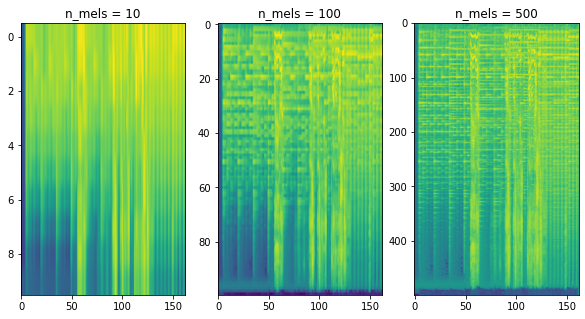

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))


for ax, mels in zip(axs, [10, 100, 500]):
    fspecgram = torchaudio.transforms.MelSpectrogram(n_mels=mels, 
                                                     n_fft=10000, 
                                                     win_length=10000, 
                                                     hop_length=4096,
                                                     sample_rate=sample_rate)
    specgram = fspecgram(torch.tensor(waveform.numpy()[:, :interval*sample_rate]))
    ax.imshow(specgram.log2()[0,:,:].detach().numpy(), aspect="auto")

    ax.set_title('n_mels = %s'%mels)

plt.show()


Чем больше размер шага, тем более подробную спектограмму имеем на выходе.

Параметры `n_fft`, `win_length`, `hop_length` используются для оконного преобразования Фурье и были подобраны нами с целью получения наименее сглаженной спектграммы и, как следствие, содержащей большее число информации

Classique
Track:   Concerto No. 2 in G minor (L'estate- Summer) RV315 (Op. 8 No. 2); III. Presto.mp3
Shape of waveform: torch.Size([2, 7410816])
Sample rate of waveform: 44100


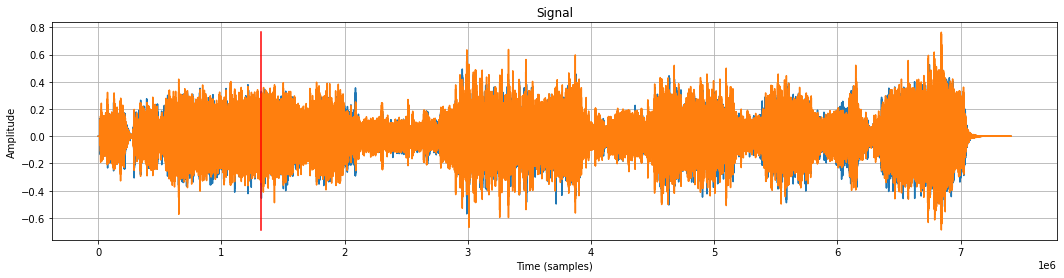

In [ ]:
filename = classique_lst[1]
waveform, sample_rate = torchaudio.load('/content/' + filename)
interval = 30 # in seconds

print('Classique')
print("Track: ", filename.split(' - ')[1])
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure(figsize=(18, 4))
plt.plot(waveform.t().numpy())
plt.grid()
plt.plot([interval*sample_rate,interval*sample_rate],
         [waveform.t().numpy().min(),waveform.t().numpy().max()],'r')
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');
pass

Shape of waveform: torch.Size([2, 1323000])


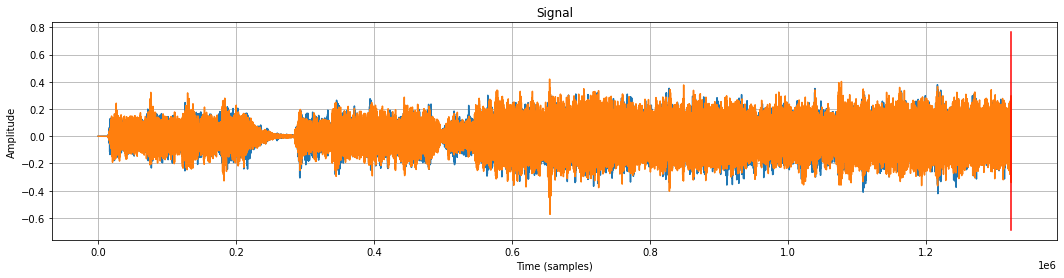

In [ ]:
print("Shape of waveform: {}".format(waveform[:,:interval*sample_rate].size()))
# print("Sample rate of waveform: {}".format(sample_rate))

plt.figure(figsize=(18, 4))
plt.plot(waveform.t().numpy()[:interval*sample_rate,:])
plt.grid()
plt.plot([interval*sample_rate,interval*sample_rate],
         [waveform.t().numpy().min(),waveform.t().numpy().max()],'r')
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');
pass

In [ ]:

fspecgram = torchaudio.transforms.MelSpectrogram(n_mels=323, 
                                                n_fft=10000, 
                                                win_length=10000, 
                                                hop_length=4096,
                                                sample_rate=sample_rate)


specgram = fspecgram(torch.tensor(waveform.numpy()[:, :interval*sample_rate]))
print("Shape of spectrogram: {}".format(specgram.size()))
fig = plt.figure(figsize=(15, 10))
img = plt.imshow(specgram.log2()[0,:,:].detach().numpy())
bar = fig.colorbar(img)
plt.ylabel('Frequency (Mel)')
plt.xlabel('Time')
bar.set_label('Power (dB)')
plt.title('Log Mel spectrogram')
pass

NameError: ignored

In [ ]:
torch.tensor(waveform.numpy()[:, :interval*sample_rate]).shape, waveform.shape

(torch.Size([2, 1323000]), torch.Size([2, 7410816]))

RAP
Track:  Шаг влево шаг вправо.mp3
Shape of waveform: torch.Size([2, 6779520])
Sample rate of waveform: 44100


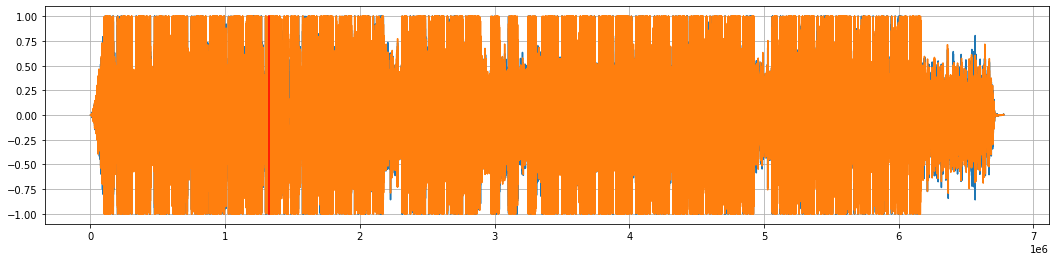

In [ ]:
filename = rap_lst[-1]
waveform, sample_rate = torchaudio.load('/content/' + filename)
interval = 30 # in seconds

print('RAP')
print("Track: ", filename.split(' - ')[1])
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure(figsize=(18, 4))
plt.plot(waveform.t().numpy())
plt.grid()
plt.plot([interval*sample_rate,interval*sample_rate],
         [waveform.t().numpy().min(),waveform.t().numpy().max()],'r')

Shape of waveform: torch.Size([2, 1323000])


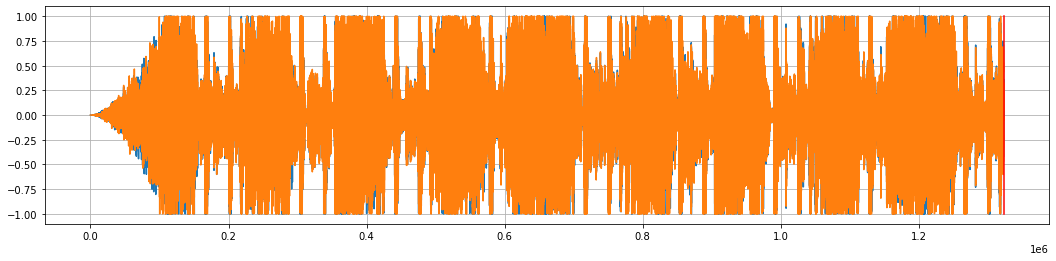

In [ ]:
print("Shape of waveform: {}".format(waveform[:,:interval*sample_rate].size()))
# print("Sample rate of waveform: {}".format(sample_rate))

plt.figure(figsize=(18, 4))
plt.plot(waveform.t().numpy()[:interval*sample_rate,:])
plt.grid()
plt.plot([interval*sample_rate,interval*sample_rate],
         [waveform.t().numpy().min(),waveform.t().numpy().max()],'r')

pass

Shape of spectrogram: torch.Size([2, 323, 1656])


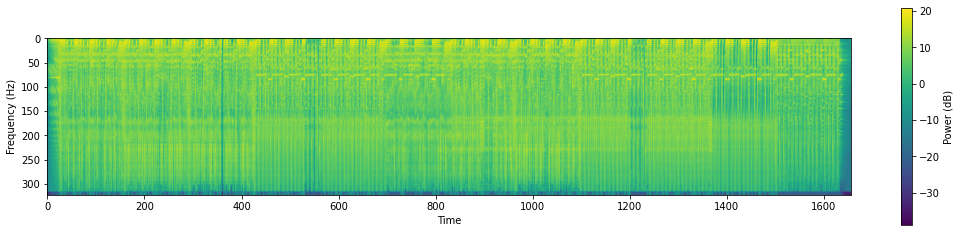

In [565]:
fspecgram = torchaudio.transforms.MelSpectrogram(n_mels=323, 
                                                n_fft=10000, 
                                                win_length=10000, 
                                                hop_length=4096,
                                                sample_rate=sample_rate)


specgram = fspecgram(torch.tensor(waveform.numpy()[:, :interval*sample_rate]))
print("Shape of spectrogram: {}".format(specgram.size()))
fig = plt.figure(figsize=(18, 10))

img = plt.imshow(specgram.log2()[0,:,:].detach().numpy())
bar = fig.colorbar(img)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time')
bar.set_label('Power (dB)')

pass

 # 3. Сэмплирование

In [ ]:
def audio2spec(filename_lst, sample_rate=sample_rate, n_mels=imgheight, n_intervals=15):
  x_dct = {}
  y_dct = {}
  for filename, genre in filename_lst:
    # print(filename)
    waveform, _ = torchaudio.load('/content/' + filename)
    fspecgram = torchaudio.transforms.MelSpectrogram(n_mels=n_mels, 
                                                    n_fft=10000, 
                                                    win_length=10000, 
                                                    hop_length=4096,
                                                    sample_rate=sample_rate)
    n_intervals = int(waveform.shape[1] / (interval*sample_rate))
    songname = filename.split(' - ')[-1]
    for i in range(n_intervals):
      specgram = fspecgram(torch.tensor(waveform.numpy()[:, i*interval*sample_rate:(i+1)*interval*sample_rate]))
      x_dct[songname+'_'+str(i+1)] = specgram
      y_dct[songname+'_'+str(i+1)] = genre
  return x_dct, y_dct

In [ ]:
interval = 15
sample_rate = 44100
imgheight, imgwidth = 400 , 162 
print('Sample_rate', sample_rate)

filename_lst =  list(zip(classique_lst, ['classique'] * len(classique_lst)))
filename_lst += list(zip(rap_lst, ['rap'] * len(rap_lst)))

filename_test_lst =  list(zip(classique_test_lst, ['classique'] * len(classique_test_lst)))
filename_test_lst += list(zip(rap_test_lst, ['rap'] * len(rap_test_lst)))

print('train')
x_dct, y_dct = audio2spec(filename_lst)
print('test')
x_test_dct, y_test_dct = audio2spec(filename_test_lst)

Sample_rate 44100
train
test


In [ ]:
import pandas as pd
import numpy as np
df =  pd.DataFrame(y_dct.items(), columns=['songname', 'genre'])
df[df.genre=='rap'].genre.count(), df[df.genre=='classique'].genre.count()
df = df.sample(len(df))
df_test =  pd.DataFrame(y_test_dct.items(), columns=['songname', 'genre'])
df_test[df_test.genre=='rap'].genre.count(), df_test[df_test.genre=='classique'].genre.count()
df_test = df_test.sample(len(df_test))
df.head()

,songname,genre
135,Hokage.mp3_8,rap
144,Homicide [ZAKACHAI1.RU].mp3_6,rap
62,Finale.mp3_5,classique
92,Peer Gynt-Incidental Music; 4.mp3_5,classique
122,Praise The Lord ( Da Shine ).mp3_8,rap


In [ ]:
x = np.zeros((len(df), imgheight, imgwidth))
y = np.zeros(len(df))
for i in range(len(df)):
    songname, genre = df.songname.iloc[i], df.genre.iloc[i]
    y[i] = 0 if genre == 'classique'  else 1
    x[i,:,:] = x_dct[songname].log2()[0,:,:]

x_test = np.zeros((len(df_test), imgheight, imgwidth))
y_test = np.zeros(len(df_test))
for i in range(len(df_test)):
    songname, genre = df_test.songname.iloc[i], df_test.genre.iloc[i]
    y_test[i] = 0 if genre == 'classique'  else 1
    x_test[i,:,:] = x_test_dct[songname].log2()[0,:,:]

In [ ]:
percent = 0.8
n = int(x.shape[0]*percent)
x_train, x_validate = x[:n], x[n:]
y_train, y_validate = y[:n], y[n:]
x_train.shape, x_test.shape

((196, 400, 162), (140, 400, 162))

In [ ]:
print('Train: N classique: %d, N rap: %d' % (y_train.shape[0] - y_train.sum(), y_train.sum()))
print('Validate: N classique: %d, N rap: %d' % (y_validate.shape[0] - y_validate.sum(), y_validate.sum()))
print('Test: N classique: %d, N rap: %d' % (y_test.shape[0] - y_test.sum(), y_test.sum()))

Train: N classique: 92, N rap: 104
Validate: N classique: 23, N rap: 27
Test: N classique: 70, N rap: 70


####Creating image data

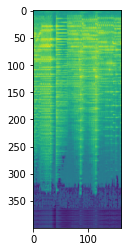

In [ ]:
from matplotlib import cm

x_train_img = np.empty(shape=(len(x_train), imgheight, imgwidth,  4))
x_validate_img = np.empty(shape=(len(x_validate), imgheight, imgwidth,  4))
x_test_img = np.empty(shape=(len(x_test), imgheight, imgwidth,  4))

for i in range(0, len(x_train)):
    x_train_img[i] = cm.viridis(x_train[i])

for i in range(0, len(x_validate)):
    x_validate_img[i] = cm.viridis(x_validate[i])

for i in range(0, len(x_test)):
    x_test_img[i] = cm.viridis(x_test[i])

x_train_img = x_train_img[:, :, :, :3]
x_validate_img = x_validate_img[:, :, :, :3]
x_test_img = x_test_img[:, :, :, :3]

# 4. Своя архитектура CNN


In [ ]:
import keras
import tensorflow as  tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.models import model_from_json
import time

In [ ]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(10,5))
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.plot(self.x, self.accuracy, '--',label="accuracy")
        plt.plot(self.x, self.val_accuracy, '--', label="val_accuracy")
        plt.grid()
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

In [ ]:
train_times = []
val_accs = []
nums_params = []

class OurGreatmodel:

  def __init__(self, x_train, y_train, x_test, y_test, 
               imheight, imwidth, num_classes=2):
      self.imheight = imheight
      self.imwidth = imwidth
      self.y_train = keras.utils.to_categorical(y_train, num_classes)
      self.y_test = keras.utils.to_categorical(y_test, num_classes)

      print("Size of Test Data:", np.shape(x_test))
      print("Size of Test Labels:", np.shape(y_test))
      print("Size of Training Data:", np.shape(x_train))
      print("Size of Training Labels:", np.shape(y_train))

      self.x_train = x_train.reshape(x_train.shape[0], imheight, imwidth, 3)
      self.x_test = x_test.reshape(x_test.shape[0], imheight, imwidth, 3)
      input_shape = (imheight, imwidth, 3)

      self.model = Sequential()
      self.model.add(Conv2D(10, kernel_size=(3, 3), strides=5, padding='same', 
                      activation='relu', input_shape=input_shape, 
                      kernel_initializer=tf.keras.initializers.truncated_normal))
      # model.add(MaxPooling2D(pool_size=(2)))
      self.model.add(BatchNormalization())
      self.model.add(Dropout(0.1))
      self.model.add(Flatten())
      self.model.add(Dense(32, activation='relu'))
      self.model.add(Dropout(0.25))
      self.model.add(Dense(num_classes, activation='softmax'))
      optimizer = keras.optimizers.SGD(learning_rate=1e-3)
      self.model.compile(loss=keras.losses.categorical_crossentropy, 
                         optimizer=optimizer , 
                         metrics=['accuracy'])
      print(self.model.summary())

  def fit(self, batch_size=20, epochs=50, plot=plot_losses):
      lr_scheduler = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
      self.history = self.model.fit(self.x_train, self.y_train, 
                                    batch_size=batch_size,
                                    epochs=epochs, verbose=0, 
                                    validation_data=(self.x_test, self.y_test),
                                    callbacks=[plot, lr_scheduler])
      
  def evaluate(self, x, y):
      x = x.reshape(x.shape[0], self.imheight, self.imwidth, 3)
      y = keras.utils.to_categorical(y, num_classes)
      y_pred = self.model.predict_classes(x)
      self.model.evaluate(x,y)
      return y_pred

  def predict(self, x):
      x = x.reshape(x.shape[0], self.imheight, self.imwidth, 3)
      y_pred_proba = self.model.predict(x)
      return y_pred_proba    

  def scheduler(self, epoch, lr):
    if epoch % 10 == 0:
      return  lr / 2
    else:
     return lr


In [ ]:
plot_losses = PlotLosses()
our_model = OurGreatmodel(x_train_img, y_train, x_validate_img, y_validate, imgheight, imgwidth)

Size of Test Data: (50, 400, 162, 3)
Size of Test Labels: (50,)
Size of Training Data: (196, 400, 162, 3)
Size of Training Labels: (196,)
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1298 (Conv2D)         (None, 80, 33, 10)        280       
_________________________________________________________________
batch_normalization_1289 (Ba (None, 80, 33, 10)        40        
_________________________________________________________________
dropout_101 (Dropout)        (None, 80, 33, 10)        0         
_________________________________________________________________
flatten_78 (Flatten)         (None, 26400)             0         
_________________________________________________________________
dense_156 (Dense)            (None, 32)                844832    
_________________________________________________________________
dropout_102 (Dropout)        (None, 32)        

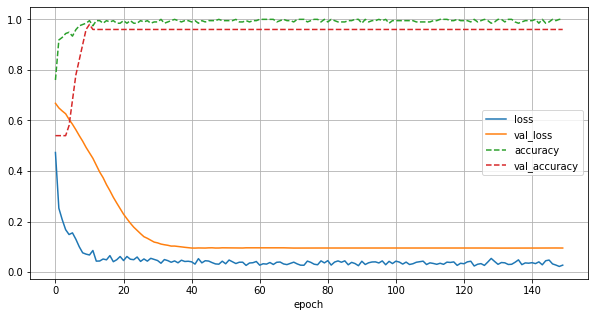

In [ ]:
train_time = time.time()
our_model.fit(batch_size=10, epochs=150)
train_times.append(time.time() - train_time)
nums_params.append(our_model.model.count_params())
val_accs.append(max(our_model.history.history['val_accuracy']))

In [ ]:
from sklearn.metrics import classification_report

y_predict = our_model.evaluate(x_test_img, y_test)
y_proba = our_model.predict(x_test_img)
print(classification_report(y_test, y_predict))

5/5 [==============================] - 0s 9ms/step - loss: 0.4762 - accuracy: 0.8500
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86        70
         1.0       0.88      0.81      0.84        70

    accuracy                           0.85       140
   macro avg       0.85      0.85      0.85       140
weighted avg       0.85      0.85      0.85       140



# 5. Известная архитектура CNN


In [ ]:
class ResNetmodel:

  def __init__(self, x_train, y_train, x_test, y_test, 
               imheight, imwidth, num_classes=2):
      self.imheight = imheight
      self.imwidth = imwidth
      self.y_train = keras.utils.to_categorical(y_train, num_classes)
      self.y_test = keras.utils.to_categorical(y_test, num_classes)

      print("Size of Test Data:", np.shape(x_test))
      print("Size of Test Labels:", np.shape(y_test))
      print("Size of Training Data:", np.shape(x_train))
      print("Size of Training Labels:", np.shape(y_train))

      self.x_train = x_train.reshape(x_train.shape[0], imheight, imwidth, 3)
      self.x_test = x_test.reshape(x_test.shape[0], imheight, imwidth, 3)
      input_shape = (imheight, imwidth, 3)

      self.model = Sequential()
      self.model.add(tf.keras.applications.InceptionResNetV2(include_top=False, 
                                                             weights='imagenet',
                                                             input_shape=input_shape))
      self.model.add(Flatten())
      self.model.add(Dense(32, activation='relu'))
      self.model.add(Dense(num_classes, activation='softmax'))
      optimizer = keras.optimizers.SGD(learning_rate=1e-3)
      self.model.compile(loss=keras.losses.categorical_crossentropy, 
                         optimizer=optimizer , 
                         metrics=['accuracy'])
      print(self.model.summary())

  def fit(self, batch_size=20, epochs=50, plot=plot_losses):
      lr_scheduler = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
      self.history = self.model.fit(self.x_train, self.y_train, 
                                    batch_size=batch_size,
                                    epochs=epochs, verbose=0, 
                                    validation_data=(self.x_test, self.y_test),
                                    callbacks=[plot])
      
  def evaluate(self, x, y):
      x = x.reshape(x.shape[0], self.imheight, self.imwidth, 3)
      y = keras.utils.to_categorical(y, num_classes)
      y_pred = self.model.predict_classes(x)
      self.model.evaluate(x,y)
      return y_pred

  def predict(self, x):
      x = x.reshape(x.shape[0], self.imheight, self.imwidth, 3)
      y_pred_proba = self.model.predict(x)
      return y_pred_proba  

  def scheduler(self, epoch, lr):
    if epoch % 10 == 0:
      return lr / 2
    else:
     return lr * tf.math.exp(-0.1)


In [ ]:
plot_losses = PlotLosses()
res_model = ResNetmodel(x_train_img, y_train, x_validate_img, y_validate, imgheight, imgwidth)

Size of Test Data: (50, 400, 162, 3)
Size of Test Labels: (50,)
Size of Training Data: (196, 400, 162, 3)
Size of Training Labels: (196,)
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 11, 3, 1536)       54336736  
_________________________________________________________________
flatten_79 (Flatten)         (None, 50688)             0         
_________________________________________________________________
dense_158 (Dense)            (None, 32)                1622048   
_________________________________________________________________
dense_159 (Dense)            (None, 2)                 66        
Total params: 55,958,850
Trainable params: 55,898,306
Non-trainable params: 60,544
_________________________________________________________________
None


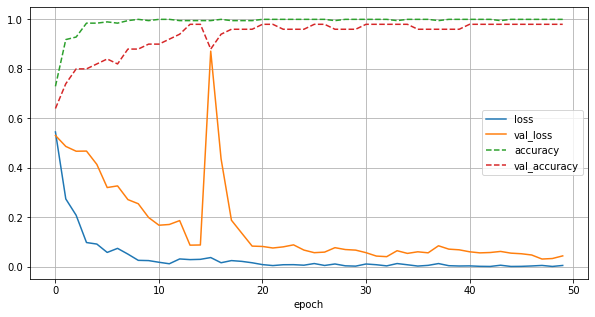

In [ ]:
train_time = time.time()
res_model.fit(batch_size=10, epochs=50)
train_times.append(time.time() - train_time)
nums_params.append(our_model.model.count_params())
val_accs.append(max(our_model.history.history['val_accuracy']))

In [ ]:
y_res_predict = res_model.evaluate(x_test_img, y_test)
print(classification_report(y_test, y_res_predict))

5/5 [==============================] - 1s 148ms/step - loss: 0.4641 - accuracy: 0.8500
              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86        70
         1.0       0.92      0.77      0.84        70

    accuracy                           0.85       140
   macro avg       0.86      0.85      0.85       140
weighted avg       0.86      0.85      0.85       140



#  6. Сравнение результатов: f1-score, матрицы ошибок


+ посчитать медианное время инференса

In [571]:
from sklearn.metrics import f1_score
report_data = {
                'Аrchitecture' : ['our CNN', 'InceptionResNetV2'],
                'parameters number' : [our_model.model.count_params(), res_model.model.count_params()], 
                'training time': train_times, 
                'validation accuracy': val_accs,
                'test accuracy': [f1_score(y_test, y_predict), f1_score(y_test, y_res_predict)]
            }
report = pd.DataFrame (report_data, columns = ['Аrchitecture',
                                              'parameters number', 
                                              'training time', 
                                              'validation accuracy', 
                                              'test accuracy'])
display(report)

,Аrchitecture,parameters number,training time,validation accuracy,test accuracy
0,our CNN,845218,52.035185,0.98,0.844444
1,InceptionResNetV2,55958850,311.132053,0.98,0.837209


In [573]:
print(report.to_markdown())

|    | Аrchitecture      |   parameters number |   training time |   validation accuracy |   test accuracy |
|---:|:------------------|--------------------:|----------------:|----------------------:|----------------:|
|  0 | our CNN           |              845218 |         52.0352 |                  0.98 |        0.844444 |
|  1 | InceptionResNetV2 |            55958850 |        311.132  |                  0.98 |        0.837209 |


Our model


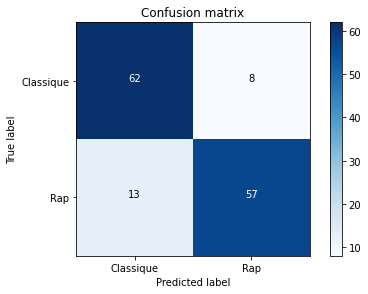

In [577]:
from sklearn.metrics import confusion_matrix,  plot_confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        # print('Confusion matrix, without normalization')
        pass

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print('Our model')
plot_confusion_matrix(confusion_matrix(y_test, y_predict, labels=[0, 1]), classes=['Classique', 'Rap'])

InceptionResNetV2


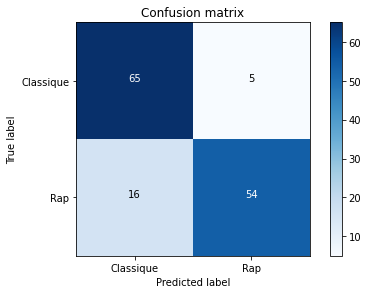

In [578]:
print('InceptionResNetV2')
plot_confusion_matrix(confusion_matrix(y_test, y_res_predict, labels=[0, 1]), classes=['Classique', 'Rap'])

#  7. Примеры классификации


In [592]:
df_test['y_test'] = y_test
df_test['part'] = df_test['songname'].apply(lambda x: int(x.split('_')[-1]))
df_test['y_our_pred'] = y_predict
df_test['y_res_pred'] = y_res_predict
df_test['classique_prob'] = np.around(y_proba[:, 0 ],2)
df_test['rap_prob'] = np.around(y_proba[:, 1 ],2)
cond = df_test['songname'].apply(lambda x: True if 'горе' in x.lower() else False)

df_test[cond].sort_values(['part'])

,songname,genre,y_test,part,y_our_pred,y_res_pred,classique_prob,rap_prob
108,Сергей Мавроди Горе не беда.mp3_1,rap,1.0,1,1,0,0.04,0.96
109,Сергей Мавроди Горе не беда.mp3_2,rap,1.0,2,0,0,0.94,0.06
110,Сергей Мавроди Горе не беда.mp3_3,rap,1.0,3,0,1,0.87,0.13
111,Сергей Мавроди Горе не беда.mp3_4,rap,1.0,4,0,1,0.86,0.14
112,Сергей Мавроди Горе не беда.mp3_5,rap,1.0,5,0,0,0.99,0.01
113,Сергей Мавроди Горе не беда.mp3_6,rap,1.0,6,0,0,0.95,0.05
114,Сергей Мавроди Горе не беда.mp3_7,rap,1.0,7,0,0,0.99,0.01
115,Сергей Мавроди Горе не беда.mp3_8,rap,1.0,8,0,0,0.82,0.18
116,Сергей Мавроди Горе не беда.mp3_9,rap,1.0,9,0,0,0.97,0.03
117,Сергей Мавроди Горе не беда.mp3_10,rap,1.0,10,0,1,0.81,0.19


In [593]:
print(df_test[cond].sort_values(['part']).to_markdown())

|     | songname                             | genre   |   y_test |   part |   y_our_pred |   y_res_pred |   classique_prob |   rap_prob |
|----:|:-------------------------------------|:--------|---------:|-------:|-------------:|-------------:|-----------------:|-----------:|
| 108 | Сергей Мавроди   Горе не беда.mp3_1  | rap     |        1 |      1 |            1 |            0 |             0.04 |       0.96 |
| 109 | Сергей Мавроди   Горе не беда.mp3_2  | rap     |        1 |      2 |            0 |            0 |             0.94 |       0.06 |
| 110 | Сергей Мавроди   Горе не беда.mp3_3  | rap     |        1 |      3 |            0 |            1 |             0.87 |       0.13 |
| 111 | Сергей Мавроди   Горе не беда.mp3_4  | rap     |        1 |      4 |            0 |            1 |             0.86 |       0.14 |
| 112 | Сергей Мавроди   Горе не беда.mp3_5  | rap     |        1 |      5 |            0 |            0 |             0.99 |       0.01 |
| 113 | Сергей Мавроди   Го

## Классика это всегда не реп, а реп это иногда классика

In [ ]:
filters, biases = our_model.model.layers[0].get_weights()

songname    Allegro.mp3_5
genre           classique
Name: 108, dtype: object


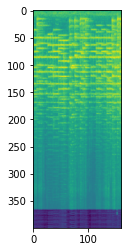

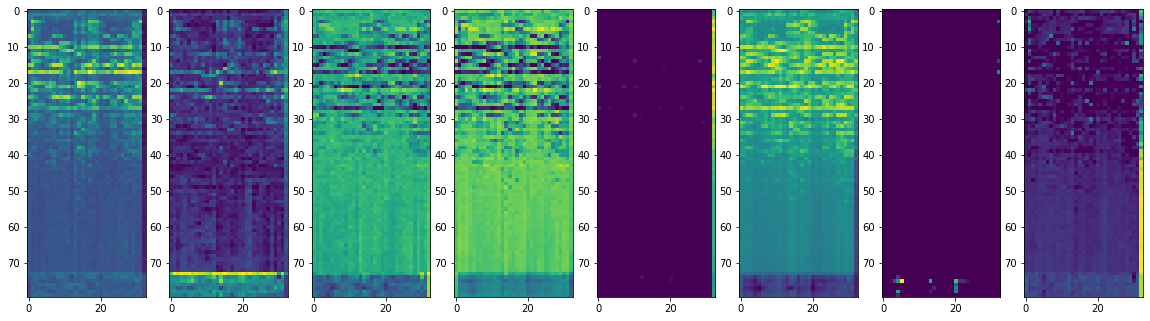

In [583]:
from tensorflow.keras.models import Model

n = 24
inp = our_model.model.inputs 
out2 = our_model.model.layers[0]. output  
feature_map_2 = Model(inputs= inp, outputs= out2) 
img = x_train_img[n] 
print(df.iloc[n])          
input_img = np.expand_dims(img, axis=0)  
plt.figure(figsize=(8, 4))
plt.imshow(img)   
f2=feature_map_2.predict(input_img)       

fig= plt.figure(figsize=(20, 50))
for i in range(8):
    ax=fig.add_subplot(8, 8, i+1)
    ax.imshow(f2[0,:,:,i])